<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [87]:
import statistics
import itertools 

import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime
from pathlib import Path

In [99]:
folder_path = r'data/student_life'
stress_folder_path = Path(folder_path) / 'EMA' / 'Stress'
gps_folder_path = Path(folder_path) / 'sensing' / 'gps'

In [89]:
def timestamp_col_to_days(df, col):
    df[col] = df[col].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))
    df[col] = pd.to_datetime(df[col])
    
def remove_rows_after_day(df, col, day):
    return df[df[col] <= pd.to_datetime(day)]

def prepare_dates(df, col):
    timestamp_col_to_days(df, col)
    return remove_rows_after_day(df, col, '2013-06-04')

def load_data():
    df_stress = pd.read_csv(stress_folder_path / 'stress.csv')
    df_stress = prepare_dates(df_stress, 'resp_time')
    df_stress = df_stress.groupby(['id','resp_time']).agg(median_stress=pd.NamedAgg(column='level', aggfunc=statistics.median))
    df_stress = pd.DataFrame(df_stress.to_records())
    
    df_gps = pd.read_csv(gps_folder_path / 'gps.csv')
    df_gps = df_gps[['id', 'time', 'latitude', 'longitude',]]
    df_gps = prepare_dates(df_gps, 'time')
    df_gps['latitude'] = df_gps['latitude'].astype(str)
    df_gps['longitude'] = df_gps['longitude'].astype(str)
    df_gps['point'] = df_gps[['latitude', 'longitude']].agg(' '.join, axis=1)
    df_gps['point'] = df_gps['point'].apply(lambda p: (float(p.split()[0]), float(p.split()[1])))
    
    return df_stress, df_gps

In [158]:
df_stress, df_gps = load_data()

In [159]:
def check_integrity():
    gps_ids = set(df_gps['id'].unique())
    stress_ids = set(df_stress['id'].unique())
    diff = gps_ids.symmetric_difference(stress_ids)
    assert not len(diff), f'id do not match: {diff}'
    
    gps_dates = set(df_gps['time'].unique())
    stress_dates = set(df_stress['resp_time'].unique())
    diff = gps_dates.symmetric_difference(stress_dates)
    assert not len(diff), f'days do not match: {diff}'

# check_integrity()
days_to_remove = ['2013-03-25', '2013-03-26', '2013-06-03', '2013-06-04', '2013-06-02']

def restore_integrity(df_stress, df_gps):
    def remove_rows_with_days(df, col, days):
        return df[~df[col].isin(days)]
    def remove_rows_with_ids(df, ids):
        return df[~df['id'].isin(ids)]
    
    df_stress = remove_rows_with_days(df_stress, 'resp_time', days_to_remove)
    df_gps = remove_rows_with_days(df_gps, 'time', days_to_remove)
    
    return df_stress, df_gps

df_stress, df_gps = restore_integrity(df_stress, df_gps)
check_integrity()

In [160]:
df_stress

id  resp_time  median_stress
2     u00 2013-03-27            1.0
3     u00 2013-03-28            2.5
4     u00 2013-03-29            2.5
5     u00 2013-03-30            4.0
6     u00 2013-03-31            4.5
...   ...        ...            ...
1059  u59 2013-05-28            2.0
1060  u59 2013-05-29            2.0
1061  u59 2013-05-30            3.5
1062  u59 2013-05-31            4.5
1063  u59 2013-06-01            3.0

[1060 rows x 3 columns]

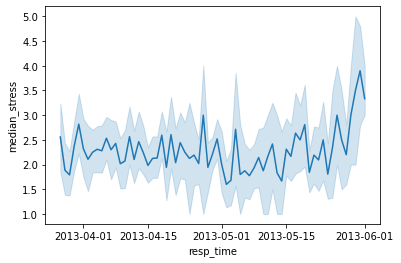

In [161]:
sns.lineplot(data=df_stress, x='resp_time', y='median_stress')

In [162]:
df_gps

id       time    latitude           longitude  \
0       u00 2013-03-27  43.7591346         -72.3292405   
1       u00 2013-03-27   43.759503        -72.32901795   
2       u00 2013-03-27  43.7591344  -72.32923819999998   
3       u00 2013-03-27  43.7591346         -72.3292405   
4       u00 2013-03-27  43.7591346         -72.3292405   
...     ...        ...         ...                 ...   
164829  u59 2013-06-01  40.9142607  -73.79201390000001   
164830  u59 2013-06-01  40.9142363         -73.7920475   
164831  u59 2013-06-01  40.9142501          -73.792028   
164832  u59 2013-06-01  40.9142466         -73.7920072   
164833  u59 2013-06-01  40.9142695         -73.7919618   

                                   point  
0              (43.7591346, -72.3292405)  
1              (43.759503, -72.32901795)  
2       (43.7591344, -72.32923819999998)  
3              (43.7591346, -72.3292405)  
4              (43.7591346, -72.3292405)  
...                                  ...  
164829  (40.9142607, -73.79201390000001)  
164830         (40.9142363, -73.7920475)  
164831          (40.9142501, -73.792028)  
164832         (40.9142466, -73.7920072)  
164833         (40.9142695, -73.7919618)  

[164834 rows x 5 columns]

In [163]:
import math
from scipy.spatial import ConvexHull

def dist(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )

def total_distance(points):
    points = points.tolist()
    distances = []    
    for i in range(1, len(points)):
        d = dist(points[i - 1], points[i])
        if math.isnan(d):
            print(d, points[i - 1], points[i])
        distances.append(d)        
    return sum(distances)

def gps_total_distance():
    df = df_gps.groupby(['id','time']).agg(total_distance=pd.NamedAgg(column='point', aggfunc=total_distance))
    return pd.DataFrame(df.to_records())

def PolyArea2D(pts):
    pts = np.array(pts.tolist())
    return ConvexHull(pts).volume if pts.shape[0] > 2 else 0

def hull_area():
    df = df_gps.groupby(['id','time']).agg(hull_area=pd.NamedAgg(column='point', aggfunc=PolyArea2D))
    return pd.DataFrame(df.to_records())['hull_area']

gdf_gps = gps_total_distance()
gdf_gps['hull_area'] = hull_area()

In [164]:
from itertools import combinations
from random import randint

def square_distance(x,y): return sum([(xi-yi)**2 for xi, yi in zip(x,y)])

def max_distance_for(points):
    points = points.tolist()
    max_square_distance = 0
    for pair in combinations(points,2):
        if square_distance(*pair) > max_square_distance:
            max_square_distance = square_distance(*pair)
            max_pair = pair
    return max_square_distance
            
def max_distance():
    df = df_gps.groupby(['id','time']).agg(max_distance=pd.NamedAgg(column='point', aggfunc=max_distance_for))
    return pd.DataFrame(df.to_records())['max_distance']

In [165]:
gdf_gps['max_distance'] = max_distance()

In [166]:
gdf_gps = gdf_gps.sort_values(['id','time'])
df_stress['time'] = df_stress['resp_time']
df_stress.drop(labels=['resp_time'], axis=1, inplace=True)
df_stress = df_stress.sort_values(['id','time'])


In [167]:
df_merged = gdf_gps.merge(df_stress, how='left', on=['id','time'])

In [198]:
df_merged["median_stress"] = df_merged[["id","median_stress"]].groupby("id").transform(lambda x: x.fillna(x.mean()))
df_merged

id       time  total_distance  hull_area  max_distance  median_stress
0     u00 2013-03-27        0.670893   0.003984      0.055396            1.0
1     u00 2013-03-28        1.772901   0.001963      0.050738            2.5
2     u00 2013-03-29        1.152223   0.002220      0.050761            2.5
3     u00 2013-03-30        0.188102   0.000635      0.004768            4.0
4     u00 2013-03-31        0.834015   0.006372      0.057665            4.5
...   ...        ...             ...        ...           ...            ...
2336  u59 2013-05-28        0.076808   0.000045      0.000133            2.0
2337  u59 2013-05-29        1.347494   0.002855      0.426993            2.0
2338  u59 2013-05-30       35.971488   0.411217      1.844308            3.5
2339  u59 2013-05-31        5.441439   1.569610     17.517842            4.5
2340  u59 2013-06-01        0.269068   0.004411      0.062574            3.0

[2341 rows x 6 columns]

In [189]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def norm(y_vec):
    return (y_vec-np.min(y_vec))/(np.max(y_vec)/np.min(y_vec))
  
#Training and testing data as numpy arrays 

X = df_merged[['total_distance','hull_area','max_distance']]
y = df_merged['median_stress']

In [190]:
X

total_distance  hull_area  max_distance
0           0.670893   0.003984      0.055396
1           1.772901   0.001963      0.050738
2           1.152223   0.002220      0.050761
3           0.188102   0.000635      0.004768
4           0.834015   0.006372      0.057665
...              ...        ...           ...
2336        0.076808   0.000045      0.000133
2337        1.347494   0.002855      0.426993
2338       35.971488   0.411217      1.844308
2339        5.441439   1.569610     17.517842
2340        0.269068   0.004411      0.062574

[2341 rows x 3 columns]

In [191]:
y = norm(y)

In [197]:
#normalize y between 0 and 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

regr.fit(X_train, y_train)

r = regr.score(X_test, y_test)

print("The r^2 score on the stress predicition was {}".format(r))

The r^2 score on the stress predicition was -0.09456638234340309
